In [ ]:
pip install pandas_ta


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pandas_ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218909 sha256=757c2e0f7568b080991892d08a5ddd307acc970bd45107419d188f5f3a01fbd0
  Stored in directory: /root/.cache/pip/wheels/69/00/ac/f7fa862c34b0e2ef320175100c233377b4c558944f12474cf0
Successfully built pandas_ta


In [ ]:
from statsmodels.regression.rolling import RollingOLS
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np
import datetime as dt
import yfinance as yf
import pandas_ta
import warnings
warnings.filterwarnings('ignore')

In [ ]:
sp500 = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]

sp500['Symbol'] = sp500['Symbol'].str.replace('.', '-')

symbols_list = sp500['Symbol'].unique().tolist()

end_date = '2023-09-30'

start_date = pd.to_datetime(end_date)-pd.DateOffset(365*9)

df = yf.download(tickers=symbols_list,
                 start=start_date,
                 end=end_date).stack()

df.index.names = ['date', 'ticker']

df.columns = df.columns.str.lower()

df

[*********************100%%**********************]  503 of 503 completed
ERROR:yfinance:
4 Failed downloads:
ERROR:yfinance:['GEV', 'VLTO', 'SW', 'SOLV']: YFChartError("%ticker%: Data doesn't exist for startDate = 1412222400, endDate = 1696046400")


Price               adj close       close        high         low        open  \
date       ticker                                                               
2014-10-02 A        36.814495   39.935623   40.228897   39.549355   40.150215   
           AAL      32.068306   33.930000   35.380001   33.509998   34.470001   
           AAPL     22.175488   24.975000   25.055000   24.510000   24.817499   
           ABBV     37.486927   56.669998   57.700001   56.139999   57.540001   
           ABT      34.038731   41.209999   41.450001   40.910000   41.220001   
...                       ...         ...         ...         ...         ...   
2023-09-29 XYL      90.233078   91.029999   91.970001   90.480003   91.849998   
           YUM     123.127518  124.940002  125.349998  124.260002  124.830002   
           ZBH     111.538483  112.220001  114.150002  111.769997  113.160004   
           ZBRA    236.529999  236.529999  241.660004  235.970001  238.690002   
           ZTS     172.269547  173.979996  175.589996  173.789993  175.589996   

Price                   volume  
date       ticker               
2014-10-02 A         2387924.0  
           AAL      21476300.0  
           AAPL    191031200.0  
           ABBV      8371500.0  
           ABT       4707100.0  
...                        ...  
2023-09-29 XYL       1833900.0  
           YUM       2610000.0  
           ZBH       1986900.0  
           ZBRA       390000.0  
           ZTS       1498500.0  

[1105515 rows x 6 columns]

### Calculate the features

In [ ]:
df['garman_klass_vol'] = ((np.log(df['high'])-np.log(df['low']))**2)/2-(2*np.log(2)-1)*((np.log(df['adj close'])-np.log(df['open']))**2)

df['rsi'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.rsi(close=x, length=20))

df['bb_low'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,0])

df['bb_mid'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,1])

df['bb_high'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,2])

def compute_atr(stock_data):
    atr = pandas_ta.atr(high=stock_data['high'],
                        low=stock_data['low'],
                        close=stock_data['close'],
                        length=14)
    return atr.sub(atr.mean()).div(atr.std())

df['atr'] = df.groupby(level=1, group_keys=False).apply(compute_atr)

def compute_macd(close):
    macd = pandas_ta.macd(close=close, length=20).iloc[:,0]
    return macd.sub(macd.mean()).div(macd.std())

df['macd'] = df.groupby(level=1, group_keys=False)['adj close'].apply(compute_macd)

df['dollar_volume'] = (df['adj close']*df['volume'])/1e6

df

Price               adj close       close        high         low        open  \
date       ticker                                                               
2014-10-02 A        36.814495   39.935623   40.228897   39.549355   40.150215   
           AAL      32.068306   33.930000   35.380001   33.509998   34.470001   
           AAPL     22.175488   24.975000   25.055000   24.510000   24.817499   
           ABBV     37.486927   56.669998   57.700001   56.139999   57.540001   
           ABT      34.038731   41.209999   41.450001   40.910000   41.220001   
...                       ...         ...         ...         ...         ...   
2023-09-29 XYL      90.233078   91.029999   91.970001   90.480003   91.849998   
           YUM     123.127518  124.940002  125.349998  124.260002  124.830002   
           ZBH     111.538483  112.220001  114.150002  111.769997  113.160004   
           ZBRA    236.529999  236.529999  241.660004  235.970001  238.690002   
           ZTS     172.269547  173.979996  175.589996  173.789993  175.589996   

Price                   volume  garman_klass_vol        rsi    bb_low  \
date       ticker                                                       
2014-10-02 A         2387924.0         -0.002761        NaN       NaN   
           AAL      21476300.0         -0.000540        NaN       NaN   
           AAPL    191031200.0         -0.004653        NaN       NaN   
           ABBV      8371500.0         -0.070549        NaN       NaN   
           ABT       4707100.0         -0.014069        NaN       NaN   
...                        ...               ...        ...       ...   
2023-09-29 XYL       1833900.0          0.000012  31.698470  4.482217   
           YUM       2610000.0         -0.000035  41.585080  4.800340   
           ZBH       1986900.0          0.000142  34.334798  4.713552   
           ZBRA       390000.0          0.000252  39.105533  5.384640   
           ZTS       1498500.0         -0.000088  39.525625  5.138618   

Price                bb_mid   bb_high       atr      macd  dollar_volume  
date       ticker                                                         
2014-10-02 A            NaN       NaN       NaN       NaN      87.910216  
           AAL          NaN       NaN       NaN       NaN     688.708559  
           AAPL         NaN       NaN       NaN       NaN    4236.209991  
           ABBV         NaN       NaN       NaN       NaN     313.821810  
           ABT          NaN       NaN       NaN       NaN     160.223709  
...                     ...       ...       ...       ...            ...  
2023-09-29 XYL     4.548971  4.615725  0.104407 -2.153777     165.478442  
           YUM     4.834853  4.869366  0.348939 -1.499041     321.362821  
           ZBH     4.775840  4.838128 -0.120096 -1.254502     221.615811  
           ZBRA    5.513969  5.643298  0.094462 -1.523967      92.246700  
           ZTS     5.198072  5.257527  0.680862 -1.598227     258.145915  

[1105515 rows x 14 columns]

### Aggregate monthly and 150 most liquid stocks for each month

In [ ]:
last_cols = [c for c in df.columns.unique(0) if c not in ['dollar_volume', 'volume', 'open',
                                                          'high', 'low', 'close']]

data = (pd.concat([df.unstack('ticker')['dollar_volume'].resample('M').mean().stack('ticker').to_frame('dollar_volume'),
                   df.unstack()[last_cols].resample('M').last().stack('ticker')],
                  axis=1)).dropna()

data

dollar_volume   adj close  garman_klass_vol        rsi  \
date       ticker                                                           
2014-11-30 A          112.969374   39.399704         -0.002514  66.391485   
           AAL        489.874293   45.982346          0.001106  75.830513   
           AAPL      4371.096384   26.514177         -0.005261  79.757518   
           ABBV       276.108343   46.116951         -0.062678  75.200842   
           ABT        152.871681   36.959778         -0.013124  63.501199   
...                          ...         ...               ...        ...   
2023-09-30 OTIS       156.435636   79.032417         -0.000133  38.542660   
           ABNB      1474.245625  137.210007          0.000563  50.809859   
           CEG        206.284073  108.246986          0.000074  55.367599   
           GEHC       226.480436   67.932831          0.000166  47.307649   
           KVUE       647.620037   19.276419         -0.000861  32.482616   

                     bb_low    bb_mid   bb_high       atr      macd  
date       ticker                                                    
2014-11-30 A       3.626446  3.666908  3.707369 -1.019730  0.374621  
           AAL     3.685625  3.747516  3.809407  1.484971  2.665344  
           AAPL    3.196737  3.264268  3.331800 -0.937672  0.255989  
           ABBV    3.723635  3.789364  3.855094 -0.987118  1.019937  
           ABT     3.606485  3.622894  3.639303 -1.068289  0.265752  
...                     ...       ...       ...       ...       ...  
2023-09-30 OTIS    4.361217  4.401380  4.441543 -1.023056 -1.500028  
           ABNB    4.871849  4.945856  5.019864 -0.956563 -0.061454  
           CEG     4.667864  4.696799  4.725733 -0.416315  0.152435  
           GEHC    4.163379  4.208899  4.254419 -0.597523 -0.650435  
           KVUE    2.991267  3.061031  3.130795 -1.315534 -1.629316  

[52244 rows x 9 columns]

In [ ]:
data['dollar_volume'] = (data.loc[:, 'dollar_volume'].unstack('ticker').rolling(5*12, min_periods=12).mean().stack())

data['dollar_vol_rank'] = (data.groupby('date')['dollar_volume'].rank(ascending=False))

data = data[data['dollar_vol_rank']<150].drop(['dollar_volume', 'dollar_vol_rank'], axis=1)

data

adj close  garman_klass_vol        rsi    bb_low  \
date       ticker                                                      
2015-10-31 AAL      44.074890         -0.000287  61.840417  3.639334   
           AAPL     26.979687         -0.004941  58.203969  3.227073   
           ABBV     40.989491         -0.044602  56.442894  3.562296   
           ABT      37.989731         -0.011553  58.030782  3.535961   
           ACN      93.213837         -0.008366  63.019450  4.467392   
...                       ...               ...        ...       ...   
2023-09-30 PYPL     58.459999          0.000213  40.494289  4.055215   
           MRNA    103.290001          0.000473  45.204540  4.574468   
           UBER     45.990002          0.000162  50.993000  3.804328   
           CRWD    167.380005          0.000114  57.427613  5.076044   
           ABNB    137.210007          0.000563  50.809859  4.871849   

                     bb_mid   bb_high       atr      macd  
date       ticker                                          
2015-10-31 AAL     3.753168  3.867002  0.728262  1.536587  
           AAPL    3.283135  3.339196 -0.801751 -0.056525  
           ABBV    3.647408  3.732519  0.567495 -0.567319  
           ABT     3.607121  3.678281 -0.752406  0.287198  
           ACN     4.519220  4.571048 -0.807398  0.426830  
...                     ...       ...       ...       ...  
2023-09-30 PYPL    4.129057  4.202898 -0.665616 -0.392605  
           MRNA    4.665740  4.757012 -0.550946 -0.356266  
           UBER    3.860307  3.916286 -0.754266 -0.113048  
           CRWD    5.115334  5.154624 -0.805349  0.250416  
           ABNB    4.945856  5.019864 -0.956563 -0.061454  

[14304 rows x 8 columns]

### Calculate Monthly Returns

In [ ]:
def calculate_returns(df):

    outlier_cutoff = 0.005

    lags = [1, 2, 3, 6, 9, 12]

    for lag in lags:

        df[f'return_{lag}m'] = (df['adj close']
                              .pct_change(lag)
                              .pipe(lambda x: x.clip(lower=x.quantile(outlier_cutoff),
                                                     upper=x.quantile(1-outlier_cutoff)))
                              .add(1)
                              .pow(1/lag)
                              .sub(1))
    return df


data = data.groupby(level=1, group_keys=False).apply(calculate_returns).dropna()

data

adj close  garman_klass_vol        rsi    bb_low  \
date       ticker                                                      
2016-10-31 AAL      39.134331         -0.000176  62.203547  3.604673   
           AAPL     26.182173         -0.002541  49.891122  3.293123   
           ABBV     39.878780         -0.049190  27.477789  3.744517   
           ABT      34.112473         -0.008074  38.008727  3.549492   
           ACN     103.117409         -0.005023  53.823697  4.633009   
...                       ...               ...        ...       ...   
2023-09-30 PYPL     58.459999          0.000213  40.494289  4.055215   
           MRNA    103.290001          0.000473  45.204540  4.574468   
           UBER     45.990002          0.000162  50.993000  3.804328   
           CRWD    167.380005          0.000114  57.427613  5.076044   
           ABNB    137.210007          0.000563  50.809859  4.871849   

                     bb_mid   bb_high       atr      macd  return_1m  \
date       ticker                                                      
2016-10-31 AAL     3.655493  3.706314  0.195402  1.014365   0.108987   
           AAPL    3.322002  3.350880 -0.952067 -0.176052   0.004335   
           ABBV    3.798670  3.852823 -0.825524 -0.760159  -0.107431   
           ABT     3.599959  3.650426 -0.934969 -0.653736  -0.066223   
           ACN     4.644646  4.656283 -0.886686 -0.137076  -0.038641   
...                     ...       ...       ...       ...        ...   
2023-09-30 PYPL    4.129057  4.202898 -0.665616 -0.392605  -0.064790   
           MRNA    4.665740  4.757012 -0.550946 -0.356266  -0.086495   
           UBER    3.860307  3.916286 -0.754266 -0.113048  -0.026254   
           CRWD    5.115334  5.154624 -0.805349  0.250416   0.026682   
           ABNB    4.945856  5.019864 -0.956563 -0.061454   0.043025   

                   return_2m  return_3m  return_6m  return_9m  return_12m  
date       ticker                                                          
2016-10-31 AAL      0.057571   0.046804   0.027572   0.005466   -0.009859  
           AAPL     0.034467   0.030850   0.034430   0.019162   -0.002497  
           ABBV    -0.062863  -0.052586  -0.011853   0.004832   -0.002287  
           ABT     -0.030579  -0.040829   0.003536   0.006089   -0.008931  
           ACN      0.010593   0.013524   0.006576   0.013037    0.008450  
...                      ...        ...        ...        ...         ...  
2023-09-30 PYPL    -0.121913  -0.043146  -0.042663  -0.021698   -0.031721  
           MRNA    -0.063054  -0.052686  -0.063975  -0.059626   -0.011208  
           UBER    -0.035717   0.021317   0.063981   0.071366    0.047012  
           CRWD     0.017538   0.044536   0.033618   0.052855    0.001290  
           ABNB    -0.050489   0.023005   0.016469   0.053165    0.022514  

[12050 rows x 14 columns]

In [ ]:
factor_data = web.DataReader('F-F_Research_Data_5_Factors_2x3',
                               'famafrench',
                               start='2010')[0].drop('RF', axis=1)

factor_data.index = factor_data.index.to_timestamp()

factor_data = factor_data.resample('M').last().div(100)

factor_data.index.name = 'date'

factor_data = factor_data.join(data['return_1m']).sort_index()

factor_data

Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                   
2016-10-31 AAL    -0.0202 -0.0402  0.0409  0.0093  0.0028   0.108987
           AAPL   -0.0202 -0.0402  0.0409  0.0093  0.0028   0.004335
           ABBV   -0.0202 -0.0402  0.0409  0.0093  0.0028  -0.107431
           ABT    -0.0202 -0.0402  0.0409  0.0093  0.0028  -0.066223
           ACN    -0.0202 -0.0402  0.0409  0.0093  0.0028  -0.038641
...                   ...     ...     ...     ...     ...        ...
2023-09-30 VRTX   -0.0524 -0.0179  0.0151  0.0191 -0.0077  -0.001722
           VZ     -0.0524 -0.0179  0.0151  0.0191 -0.0077  -0.073471
           WFC    -0.0524 -0.0179  0.0151  0.0191 -0.0077  -0.010414
           WMT    -0.0524 -0.0179  0.0151  0.0191 -0.0077  -0.016481
           XOM    -0.0524 -0.0179  0.0151  0.0191 -0.0077   0.057469

[12050 rows x 6 columns]

In [ ]:
observations = factor_data.groupby(level=1).size()

valid_stocks = observations[observations >= 10]

factor_data = factor_data[factor_data.index.get_level_values('ticker').isin(valid_stocks.index)]

factor_data

Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                   
2016-10-31 AAL    -0.0202 -0.0402  0.0409  0.0093  0.0028   0.108987
           AAPL   -0.0202 -0.0402  0.0409  0.0093  0.0028   0.004335
           ABBV   -0.0202 -0.0402  0.0409  0.0093  0.0028  -0.107431
           ABT    -0.0202 -0.0402  0.0409  0.0093  0.0028  -0.066223
           ACN    -0.0202 -0.0402  0.0409  0.0093  0.0028  -0.038641
...                   ...     ...     ...     ...     ...        ...
2023-09-30 VRTX   -0.0524 -0.0179  0.0151  0.0191 -0.0077  -0.001722
           VZ     -0.0524 -0.0179  0.0151  0.0191 -0.0077  -0.073471
           WFC    -0.0524 -0.0179  0.0151  0.0191 -0.0077  -0.010414
           WMT    -0.0524 -0.0179  0.0151  0.0191 -0.0077  -0.016481
           XOM    -0.0524 -0.0179  0.0151  0.0191 -0.0077   0.057469

[12021 rows x 6 columns]

In [ ]:
betas = (factor_data.groupby(level=1,
                            group_keys=False)
         .apply(lambda x: RollingOLS(endog=x['return_1m'],
                                     exog=sm.add_constant(x.drop('return_1m', axis=1)),
                                     window=min(24, x.shape[0]),
                                     min_nobs=len(x.columns)+1)
         .fit(params_only=True)
         .params
         .drop('const', axis=1)))

betas

Mkt-RF       SMB       HML       RMW       CMA
date       ticker                                                  
2016-10-31 AAL          NaN       NaN       NaN       NaN       NaN
           AAPL         NaN       NaN       NaN       NaN       NaN
           ABBV         NaN       NaN       NaN       NaN       NaN
           ABT          NaN       NaN       NaN       NaN       NaN
           ACN          NaN       NaN       NaN       NaN       NaN
...                     ...       ...       ...       ...       ...
2023-09-30 VRTX    0.467846 -0.437427 -0.309275 -0.065548  0.806584
           VZ      0.344257 -0.152622  0.258314  0.307387  0.117954
           WFC     1.115396  0.302806  2.045262 -0.439351 -1.518522
           WMT     0.712851 -0.293548 -0.445552 -0.147027  0.559887
           XOM     0.968446 -1.112285  1.792902 -0.620997 -0.444386

[12021 rows x 5 columns]

In [ ]:
factors = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']

data = (data.join(betas.groupby('ticker').shift()))

data.loc[:, factors] = data.groupby('ticker', group_keys=False)[factors].apply(lambda x: x.fillna(x.mean()))

data = data.drop('adj close', axis=1)

data = data.dropna()

data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 11798 entries, (Timestamp('2016-10-31 00:00:00'), 'AAL') to (Timestamp('2023-09-30 00:00:00'), 'CRWD')
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   garman_klass_vol  11798 non-null  float64
 1   rsi               11798 non-null  float64
 2   bb_low            11798 non-null  float64
 3   bb_mid            11798 non-null  float64
 4   bb_high           11798 non-null  float64
 5   atr               11798 non-null  float64
 6   macd              11798 non-null  float64
 7   return_1m         11798 non-null  float64
 8   return_2m         11798 non-null  float64
 9   return_3m         11798 non-null  float64
 10  return_6m         11798 non-null  float64
 11  return_9m         11798 non-null  float64
 12  return_12m        11798 non-null  float64
 13  Mkt-RF            11798 non-null  float64
 14  SMB               11798 non-null  float64
 15  HML       

In [ ]:
column_order = [
    'atr', 'bb_high', 'bb_low', 'bb_mid', 'garman_klass_vol', 'macd',
    'rsi', 'return_1m', 'return_2m', 'return_3m', 'return_6m',
    'return_9m', 'return_12m', 'Mkt-RF', 'SMB', 'HML', 'RMW',
    'CMA', 'cluster'
]
data = data[column_order]


In [ ]:
from sklearn.cluster import KMeans

data = data.drop('cluster', axis=1)

def get_clusters(df):
    df['cluster'] = KMeans(n_clusters=4,
                           random_state=0,
                           init='random').fit(df).labels_
    return df

data = data.dropna().groupby('date', group_keys=False).apply(get_clusters)

data

atr   bb_high    bb_low    bb_mid  garman_klass_vol  \
date       ticker                                                             
2016-10-31 AAL     0.195402  3.706314  3.604673  3.655493         -0.000176   
           AAPL   -0.952067  3.350880  3.293123  3.322002         -0.002541   
           ABBV   -0.825524  3.852823  3.744517  3.798670         -0.049190   
           ABT    -0.934969  3.650426  3.549492  3.599959         -0.008074   
           ACN    -0.886686  4.656283  4.633009  4.644646         -0.005023   
...                     ...       ...       ...       ...               ...   
2023-09-30 XOM     0.931231  4.761945  4.698426  4.730186         -0.000649   
           PYPL   -0.665616  4.202898  4.055215  4.129057          0.000213   
           MRNA   -0.550946  4.757012  4.574468  4.665740          0.000473   
           UBER   -0.754266  3.916286  3.804328  3.860307          0.000162   
           CRWD   -0.805349  5.154624  5.076044  5.115334          0.000114   

                       macd        rsi  return_1m  return_2m  return_3m  \
date       ticker                                                         
2016-10-31 AAL     1.014365  62.203547   0.108987   0.057571   0.046804   
           AAPL   -0.176052  49.891122   0.004335   0.034467   0.030850   
           ABBV   -0.760159  27.477789  -0.107431  -0.062863  -0.052586   
           ABT    -0.653736  38.008727  -0.066223  -0.030579  -0.040829   
           ACN    -0.137076  53.823697  -0.038641   0.010593   0.013524   
...                     ...        ...        ...        ...        ...   
2023-09-30 XOM     1.663926  58.863421   0.057469   0.051383   0.033937   
           PYPL   -0.392605  40.494289  -0.064790  -0.121913  -0.043146   
           MRNA   -0.356266  45.204540  -0.086495  -0.063054  -0.052686   
           UBER   -0.113048  50.993000  -0.026254  -0.035717   0.021317   
           CRWD    0.250416  57.427613   0.026682   0.017538   0.044536   

                   return_6m  return_9m  return_12m    Mkt-RF       SMB  \
date       ticker                                                         
2016-10-31 AAL      0.027572   0.005466   -0.009859  1.339508  1.130576   
           AAPL     0.034430   0.019162   -0.002497  1.109260 -0.222683   
           ABBV    -0.011853   0.004832   -0.002287  0.620176  0.169897   
           ABT      0.003536   0.006089   -0.008931  0.858793 -0.256913   
           ACN      0.006576   0.013037    0.008450  1.159582 -0.149699   
...                      ...        ...         ...       ...       ...   
2023-09-30 XOM      0.014528   0.009869    0.027894  0.999112 -1.058712   
           PYPL    -0.042663  -0.021698   -0.031721  1.586241 -0.205800   
           MRNA    -0.063975  -0.059626   -0.011208  1.155517  0.767772   
           UBER     0.063981   0.071366    0.047012  1.080479  1.180797   
           CRWD     0.033618   0.052855    0.001290  0.595945 -0.916784   

                        HML       RMW       CMA  cluster  
date       ticker                                         
2016-10-31 AAL     0.651895  0.687408  0.399442        3  
           AAPL   -0.598172  0.630160 -0.127148        1  
           ABBV    0.096201 -0.178457 -0.025152        0  
           ABT    -0.508181  0.102018  0.903893        2  
           ACN    -0.294367  0.246589  0.074113        1  
...                     ...       ...       ...      ...  
2023-09-30 XOM     1.726125 -0.659884 -0.332901        2  
           PYPL    0.259107 -1.480282 -0.249393        0  
           MRNA   -1.156852  0.597846  0.995470        3  
           UBER   -0.303488 -1.488702 -0.381346        3  
           CRWD   -0.739516 -2.459211 -0.722896        2  

[11798 rows x 19 columns]

In [ ]:
def plot_clusters(data):

    cluster_0 = data[data['cluster']==0]
    cluster_1 = data[data['cluster']==1]
    cluster_2 = data[data['cluster']==2]
    cluster_3 = data[data['cluster']==3]

    plt.scatter(cluster_0.iloc[:,0] , cluster_0.iloc[:,6] , color = 'red', label='cluster 0')
    plt.scatter(cluster_1.iloc[:,0] , cluster_1.iloc[:,6] , color = 'green', label='cluster 1')
    plt.scatter(cluster_2.iloc[:,0] , cluster_2.iloc[:,6] , color = 'blue', label='cluster 2')
    plt.scatter(cluster_3.iloc[:,0] , cluster_3.iloc[:,6] , color = 'black', label='cluster 3')

    plt.legend()
    plt.show()
    return

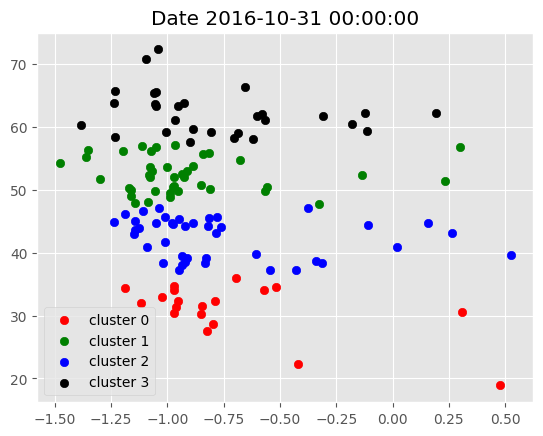

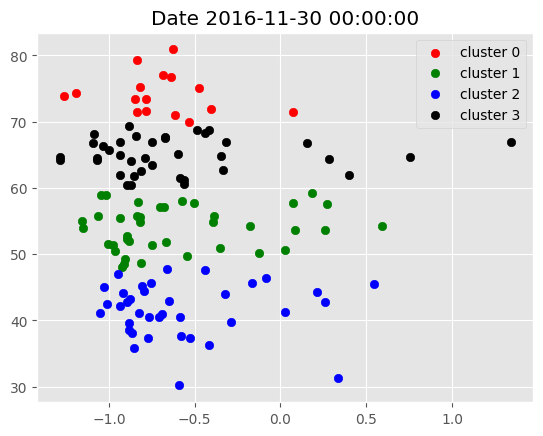

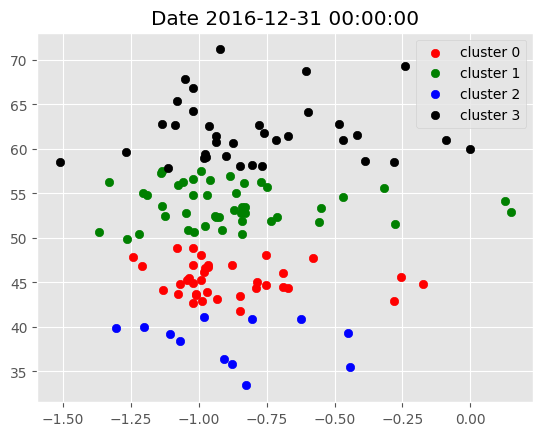

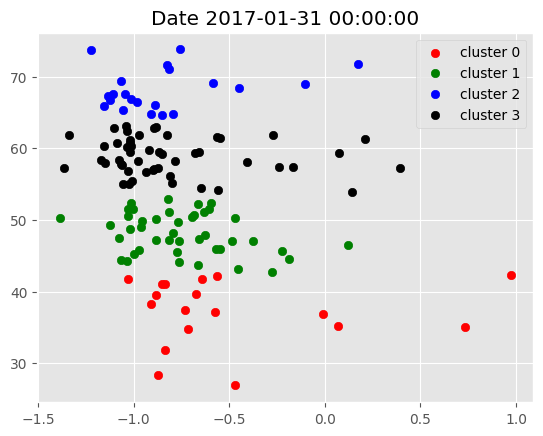

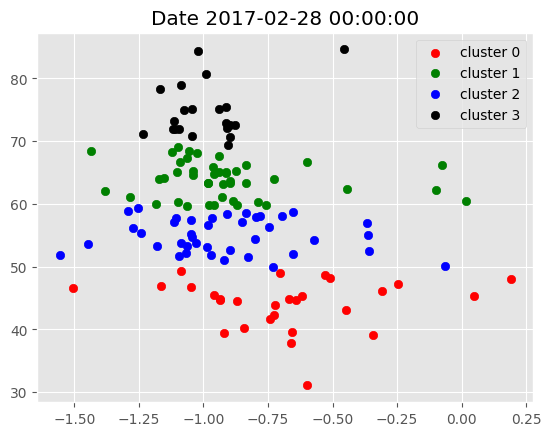

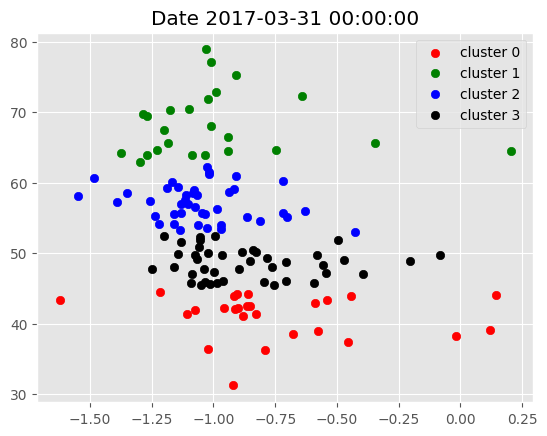

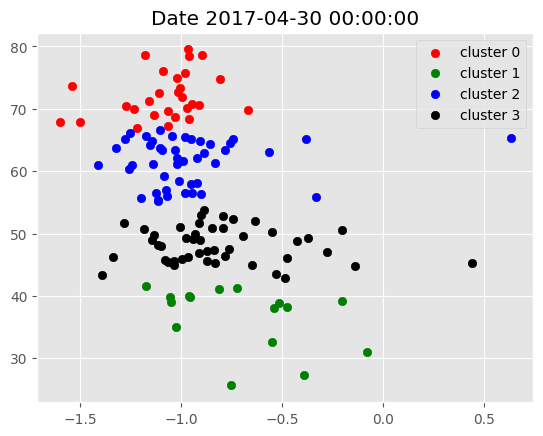

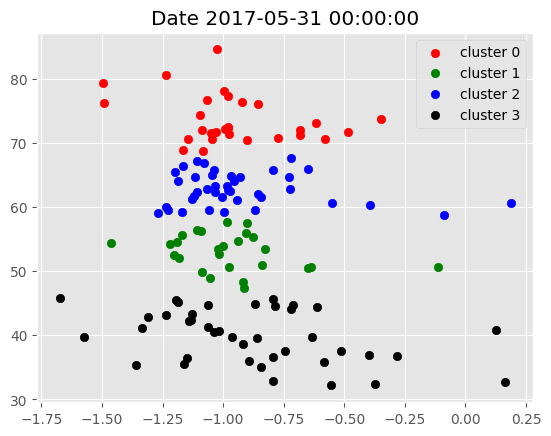

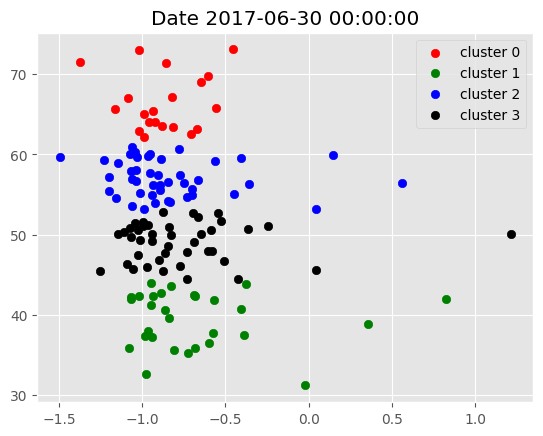

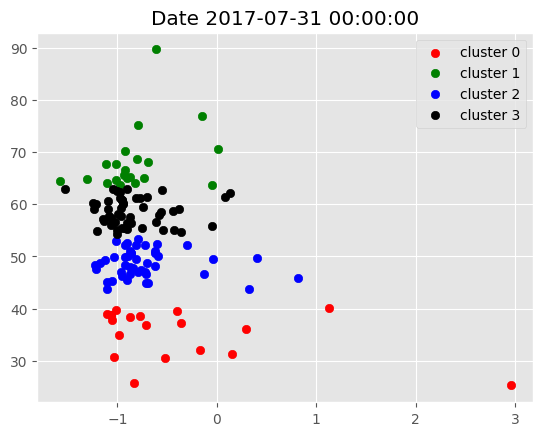

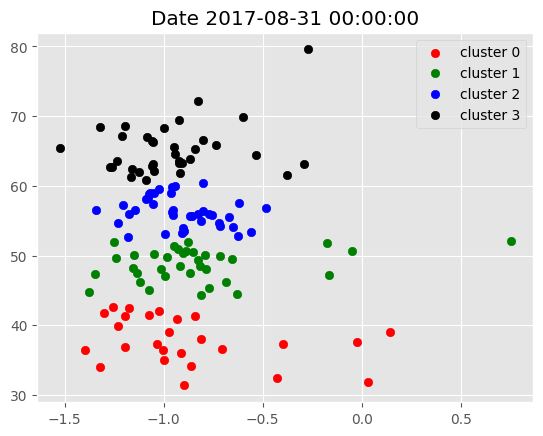

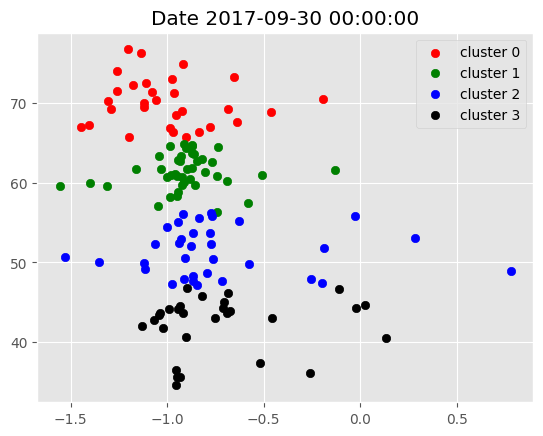

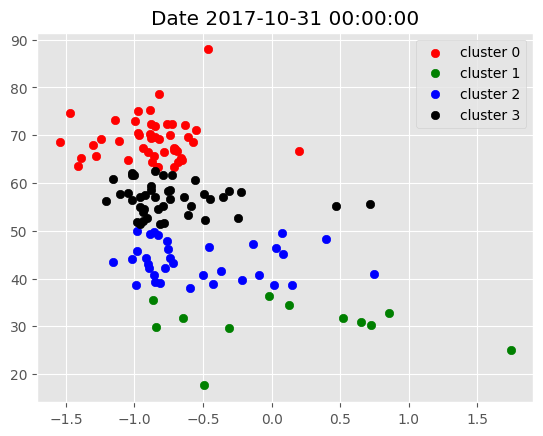

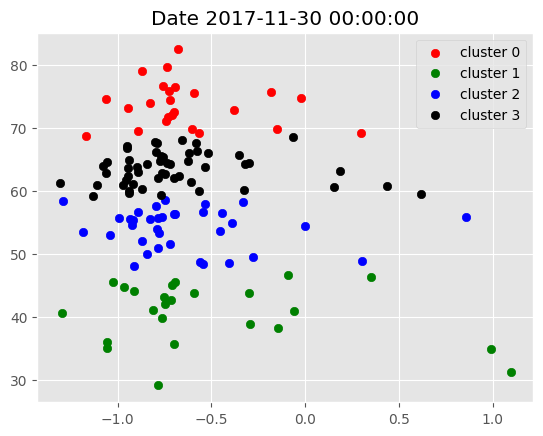

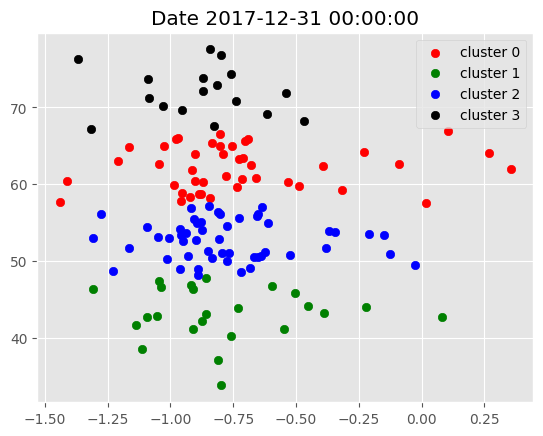

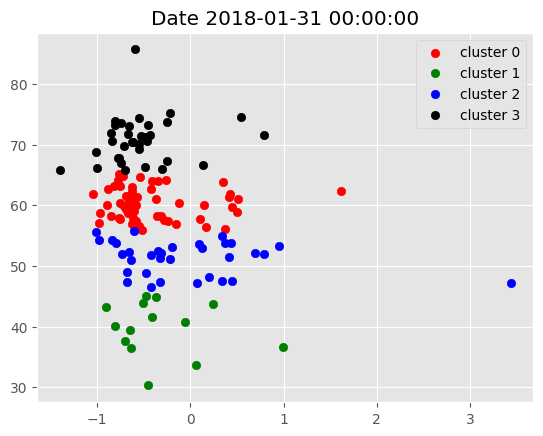

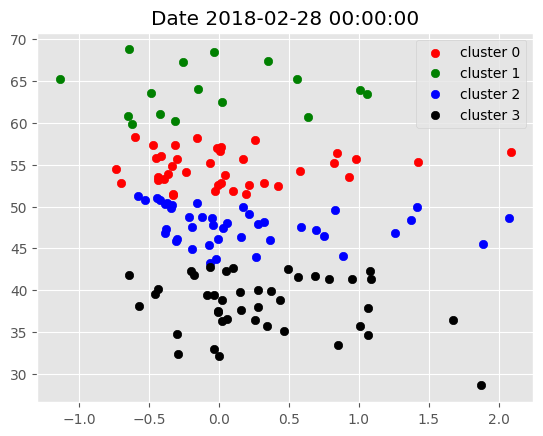

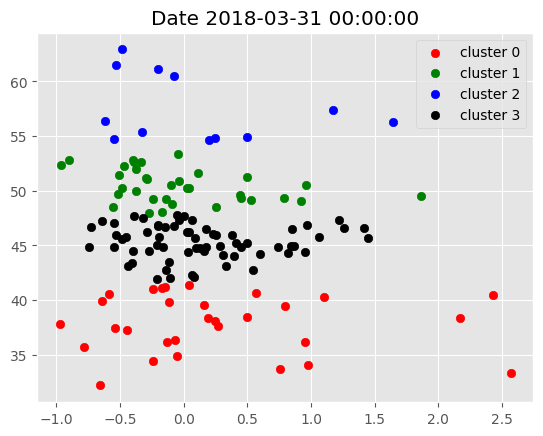

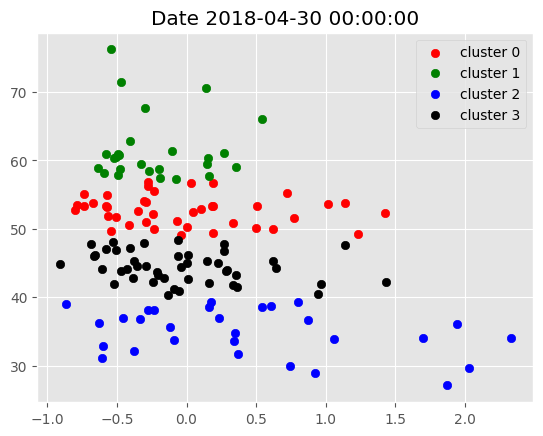

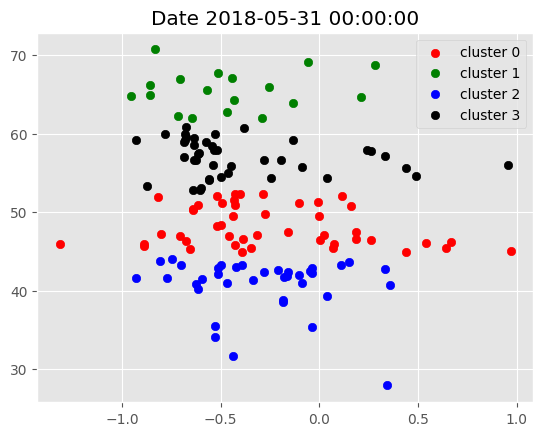

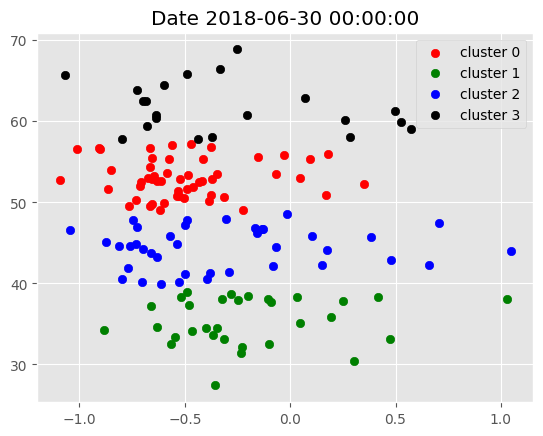

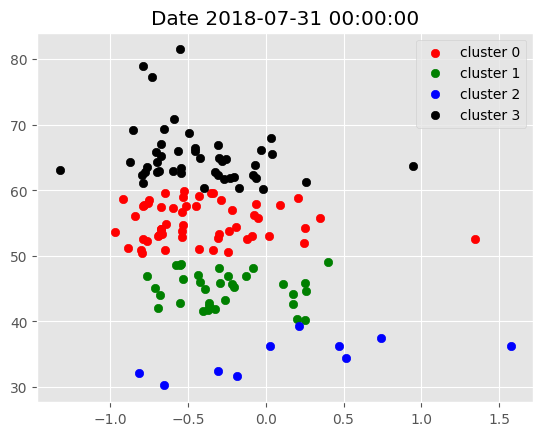

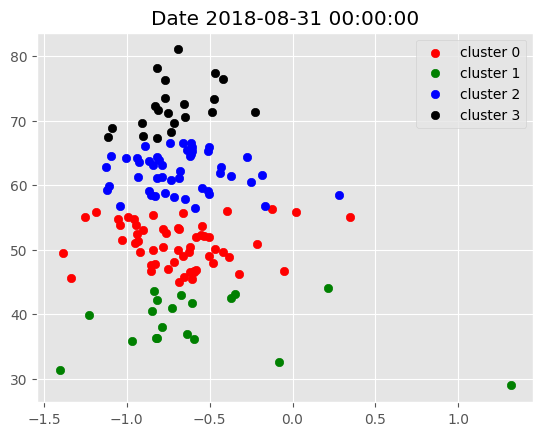

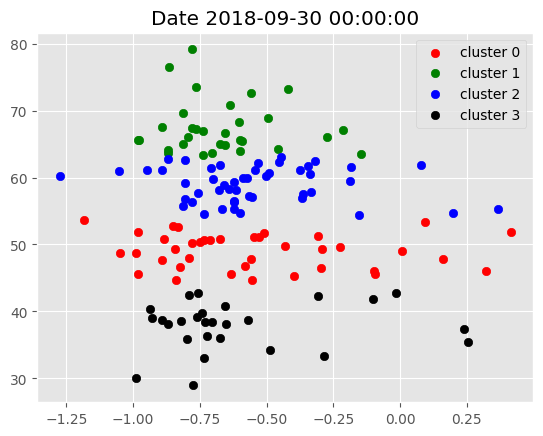

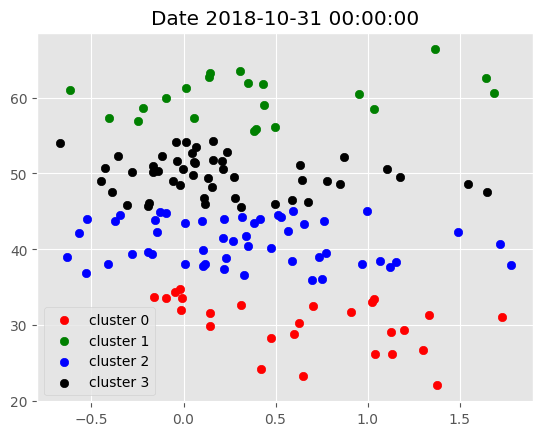

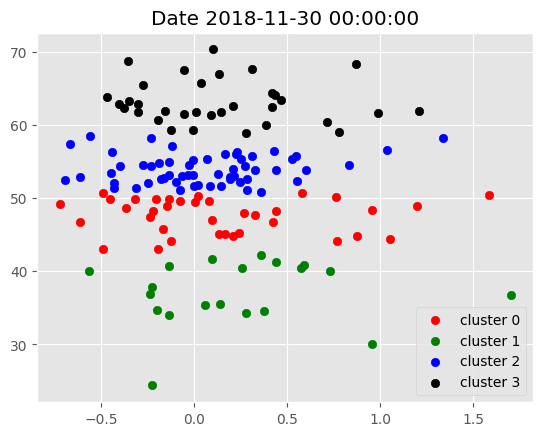

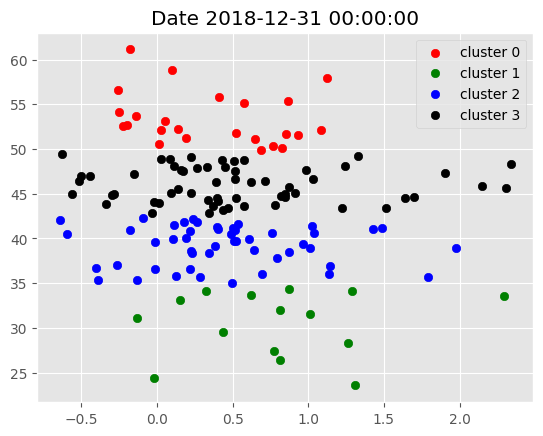

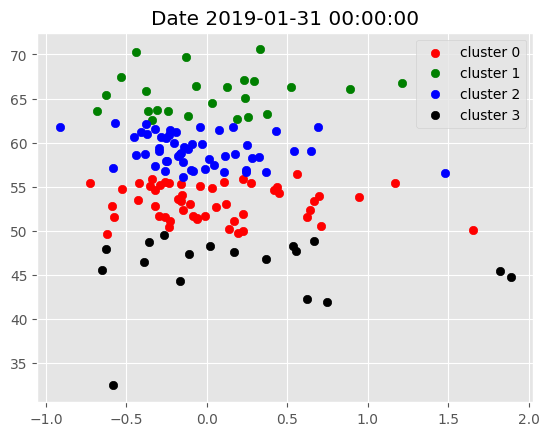

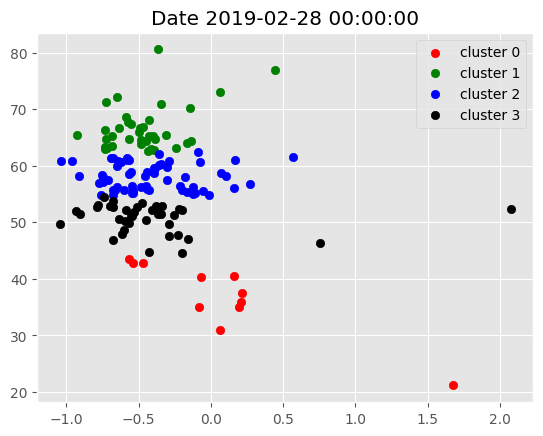

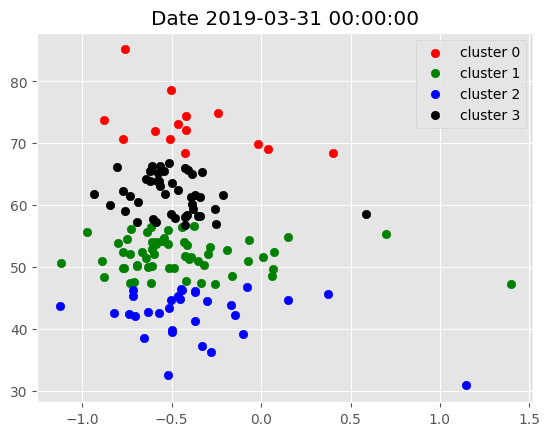

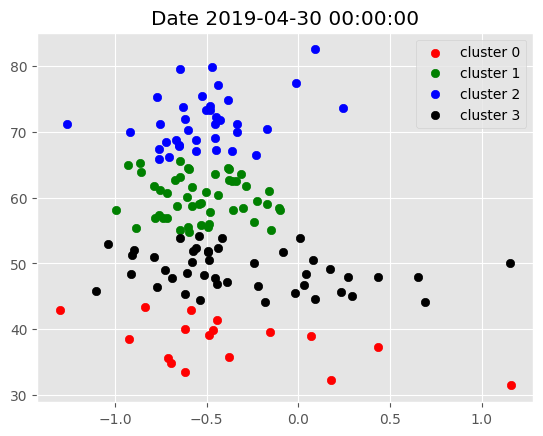

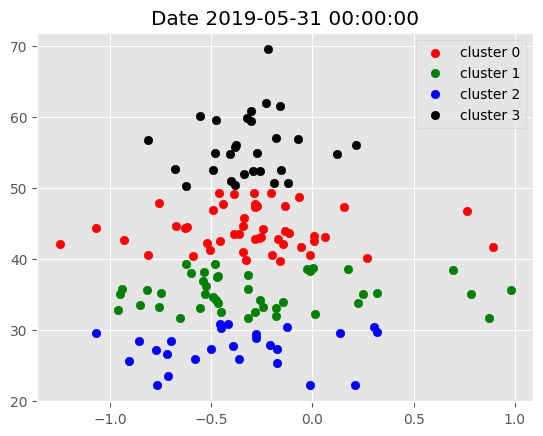

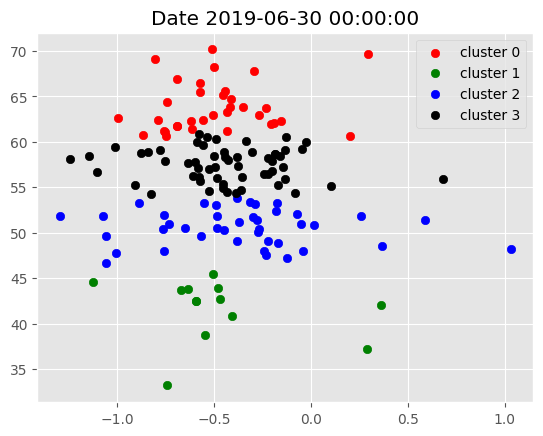

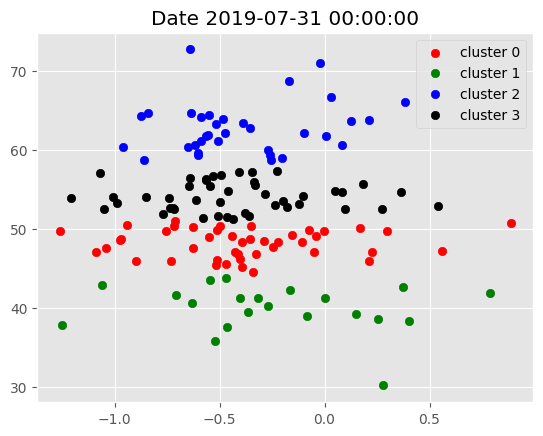

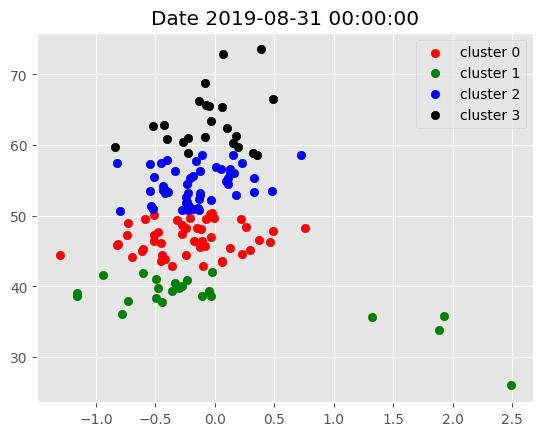

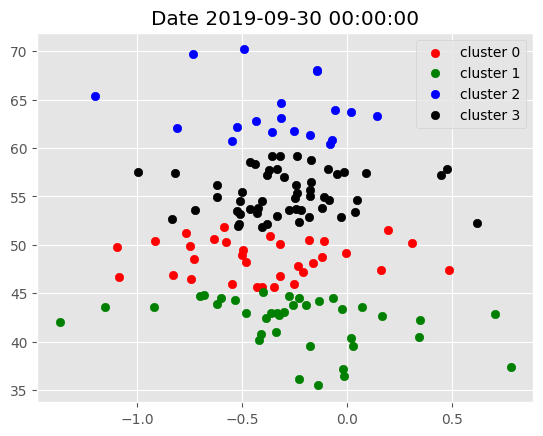

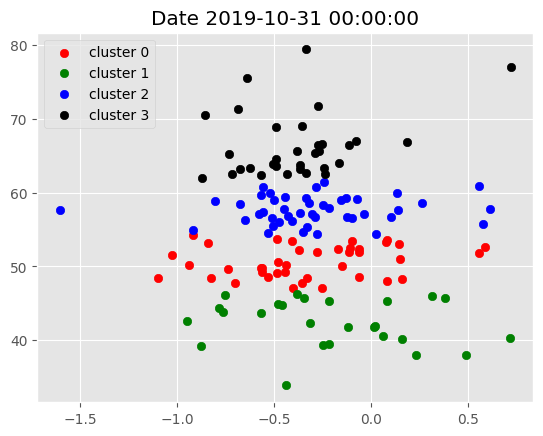

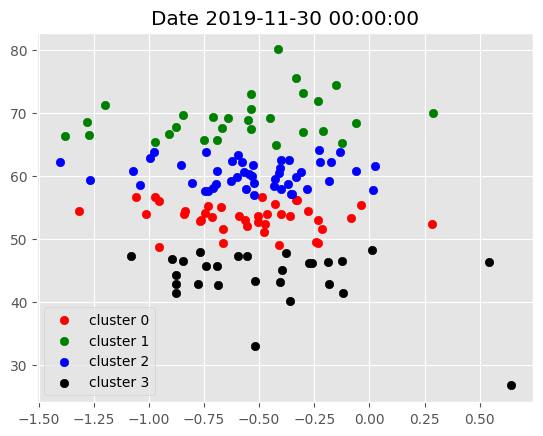

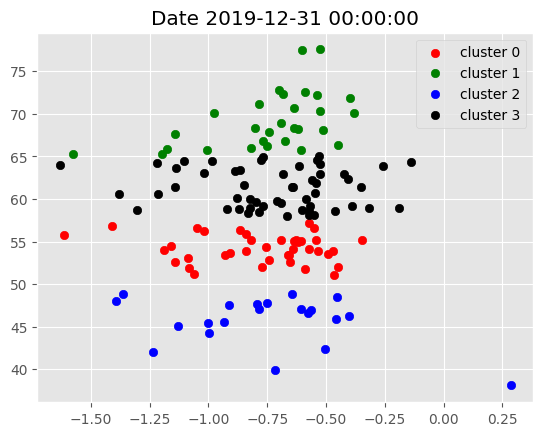

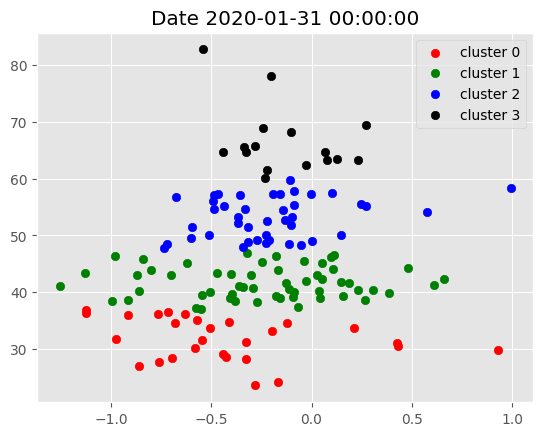

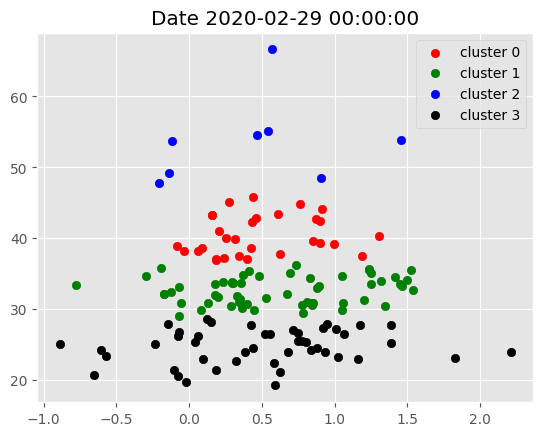

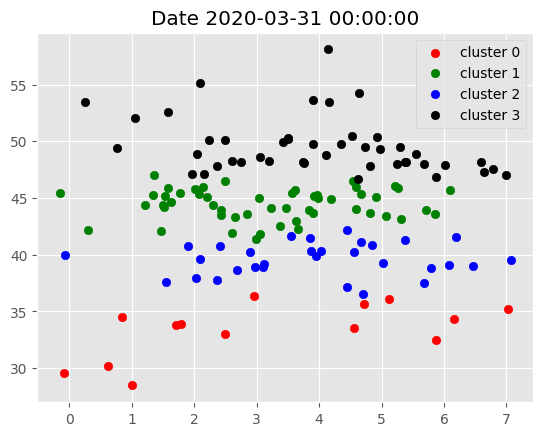

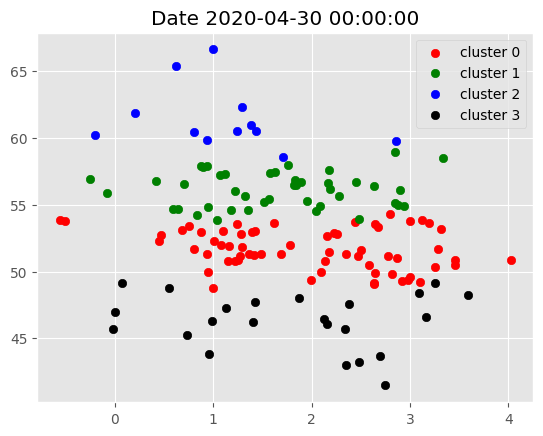

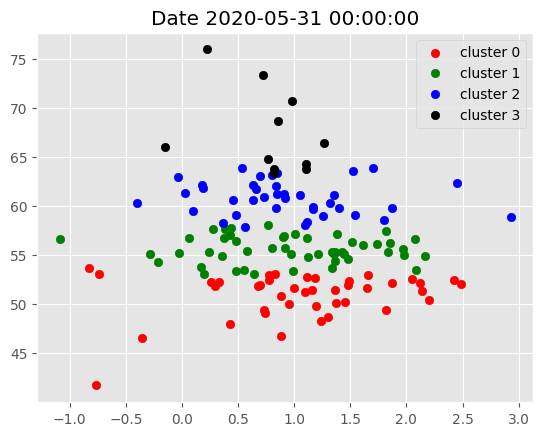

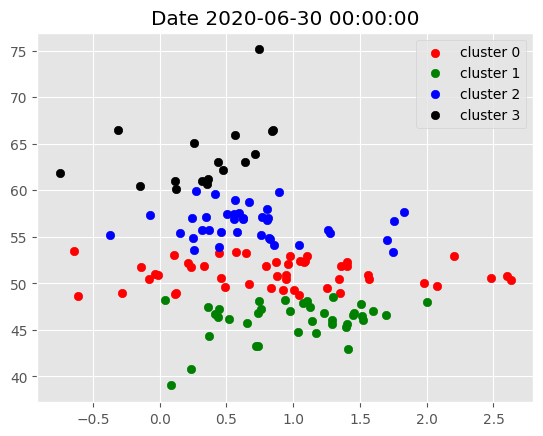

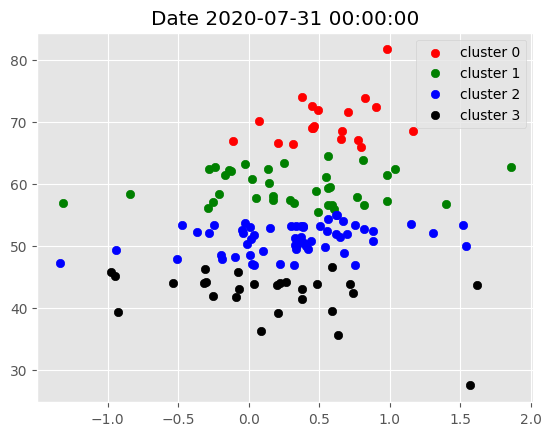

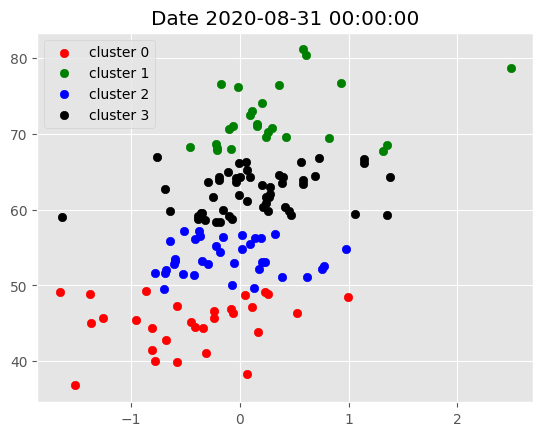

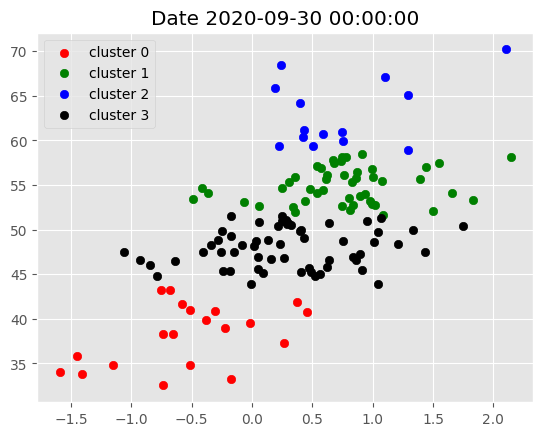

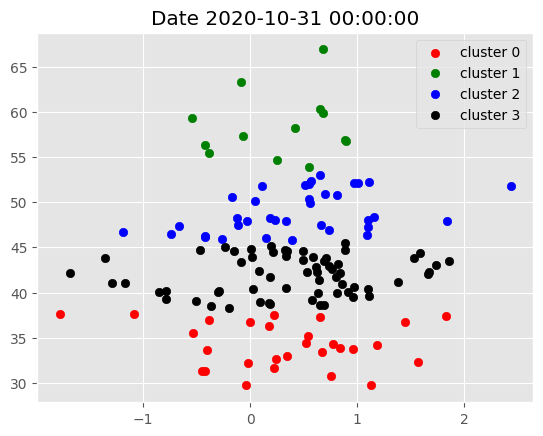

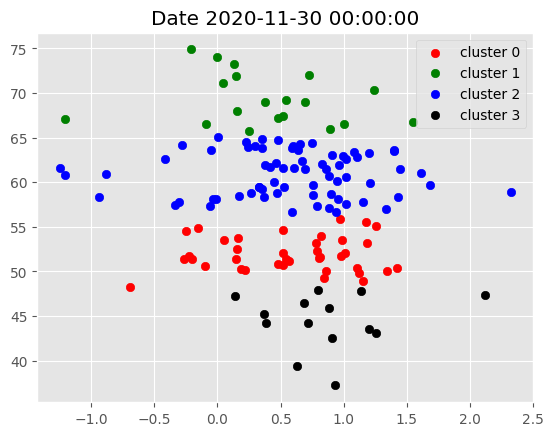

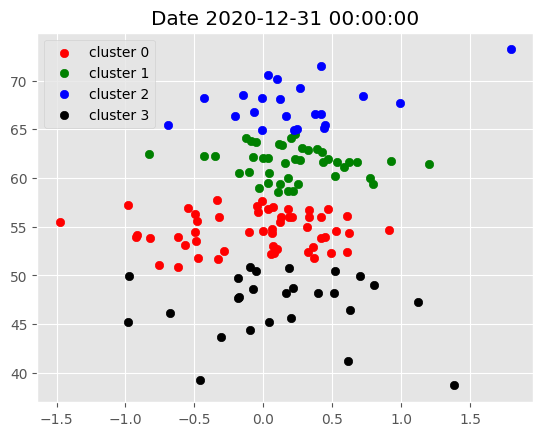

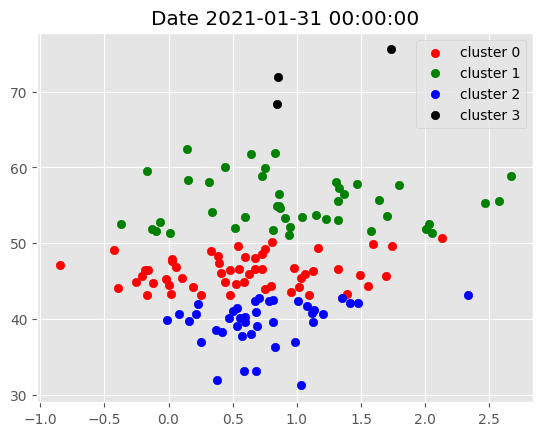

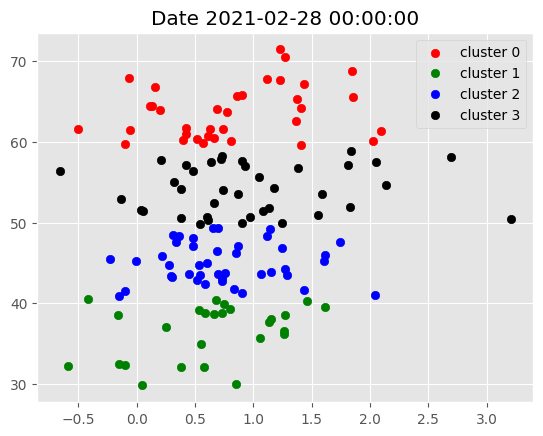

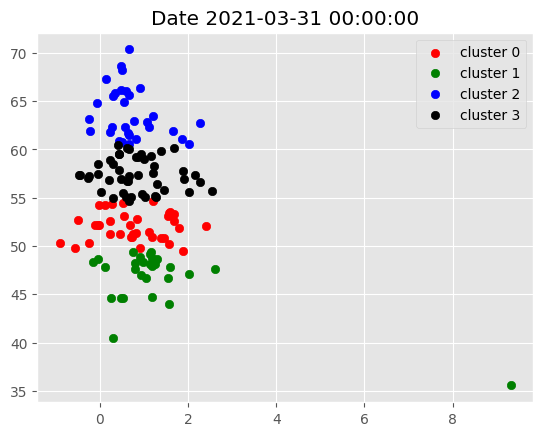

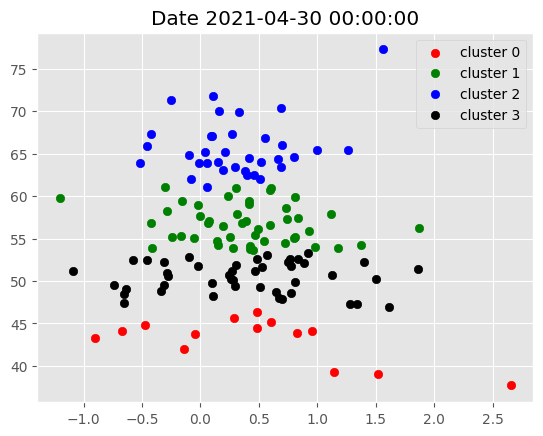

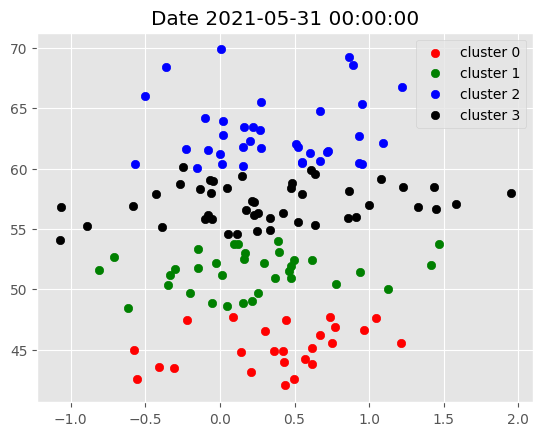

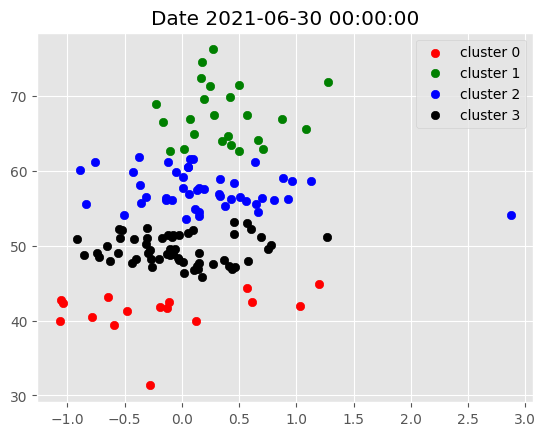

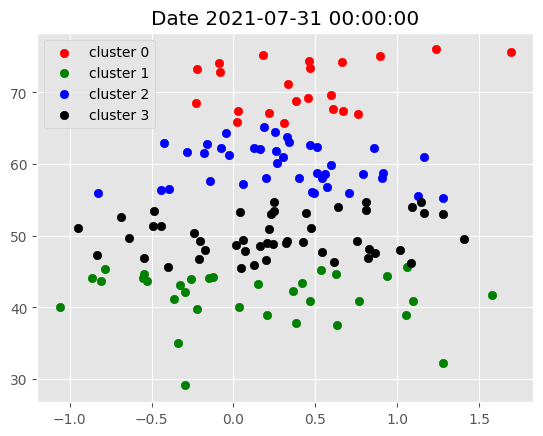

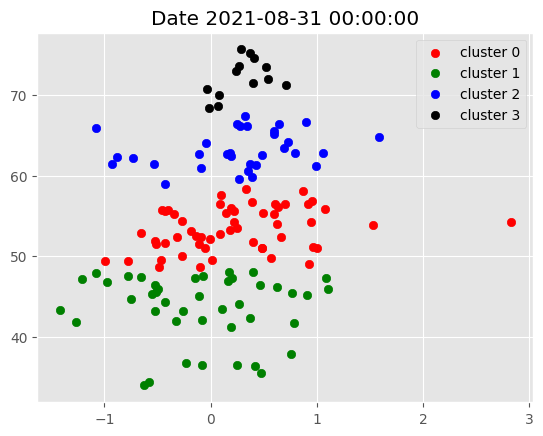

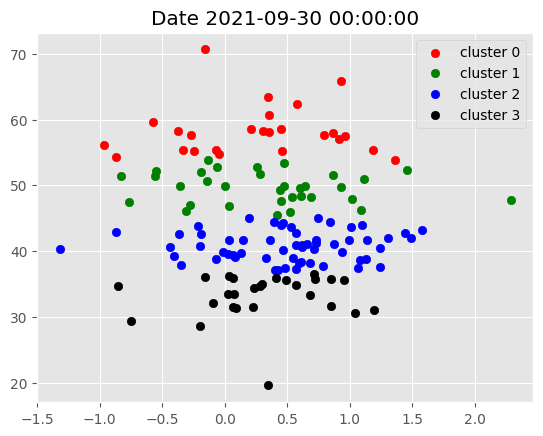

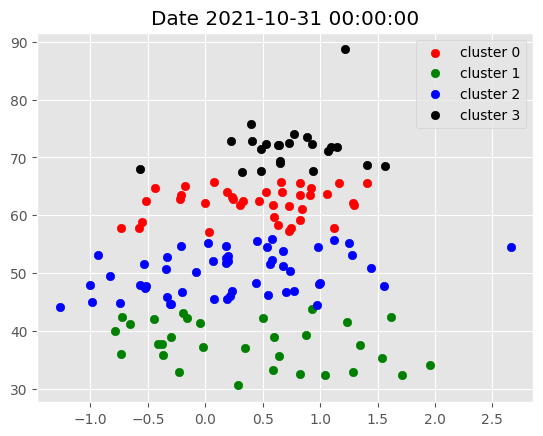

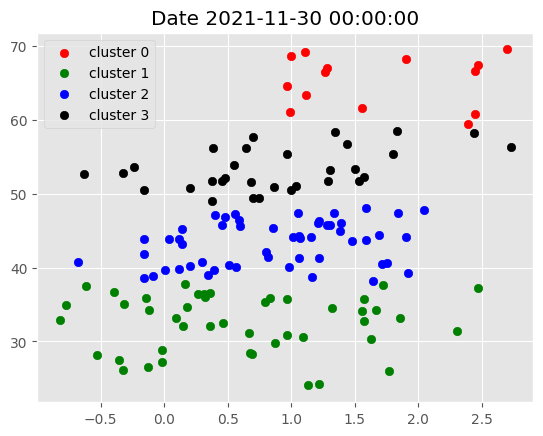

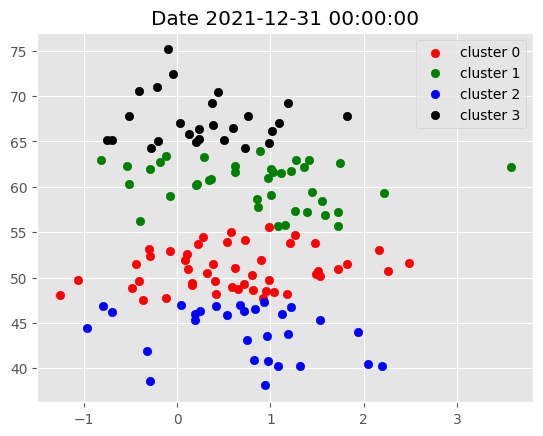

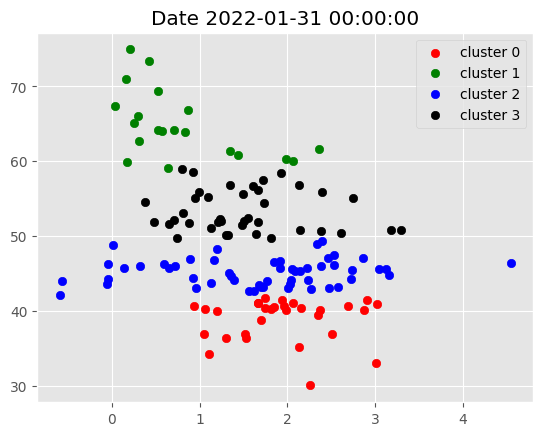

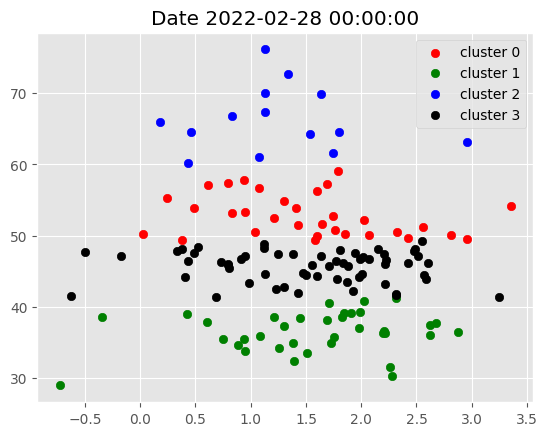

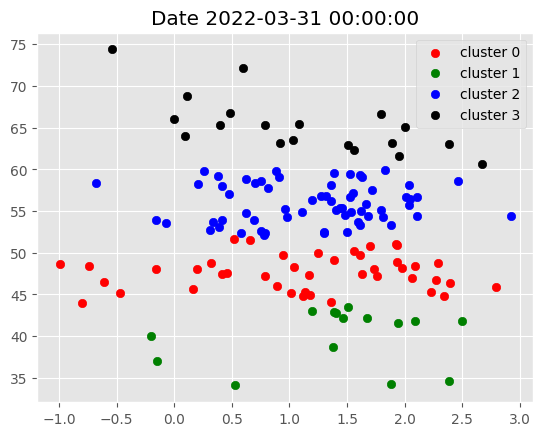

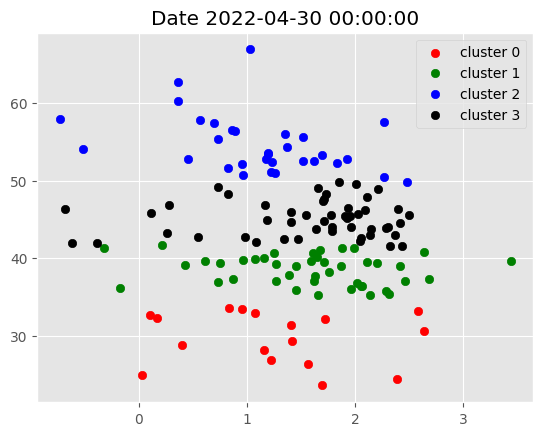

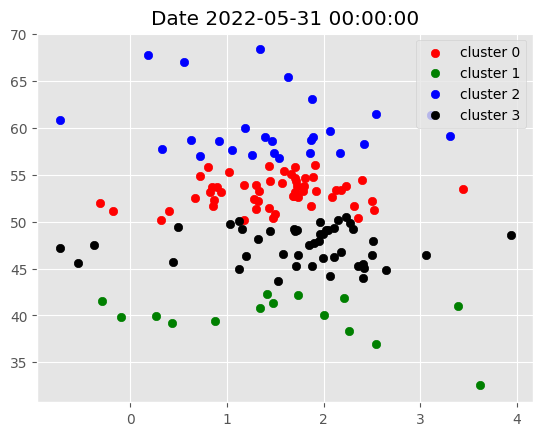

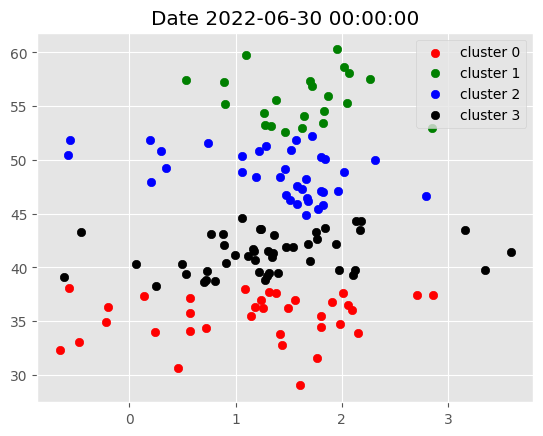

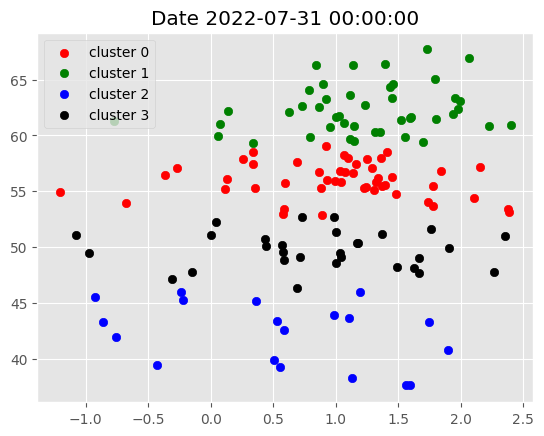

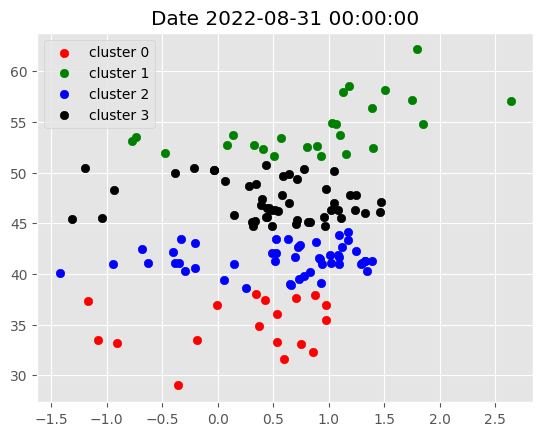

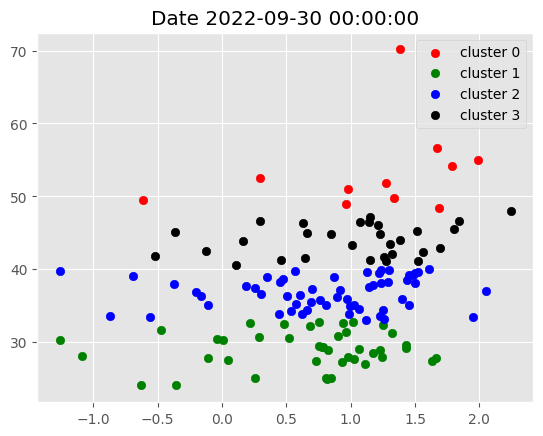

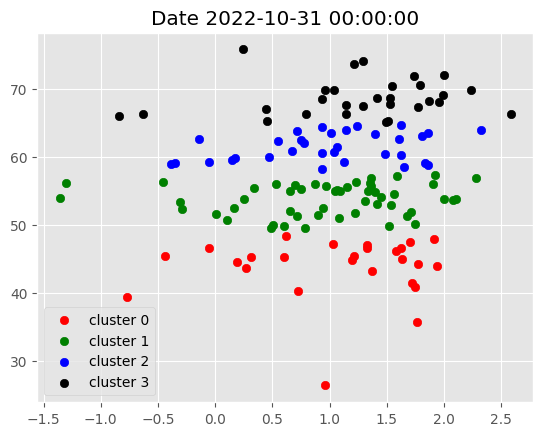

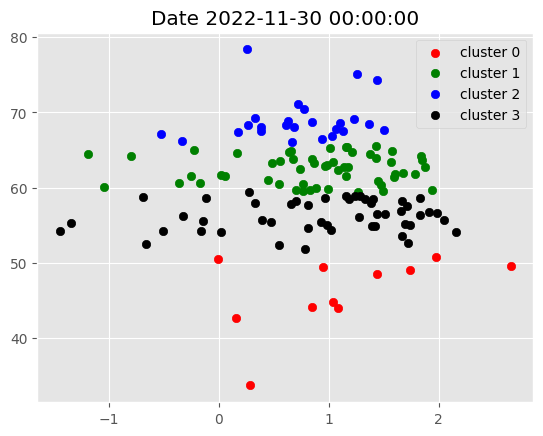

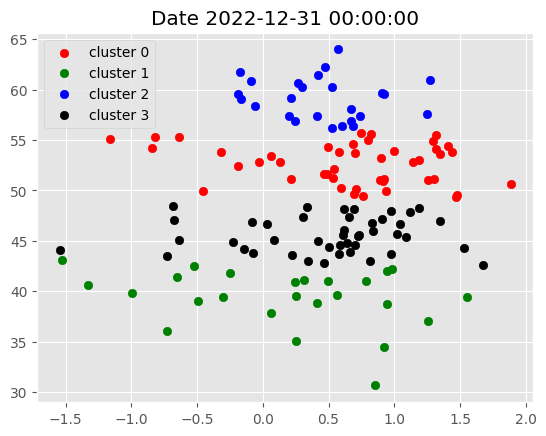

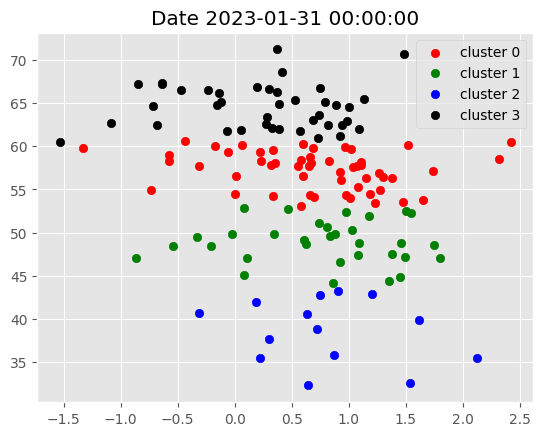

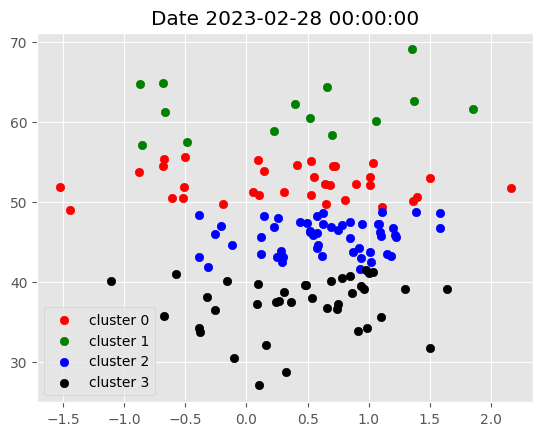

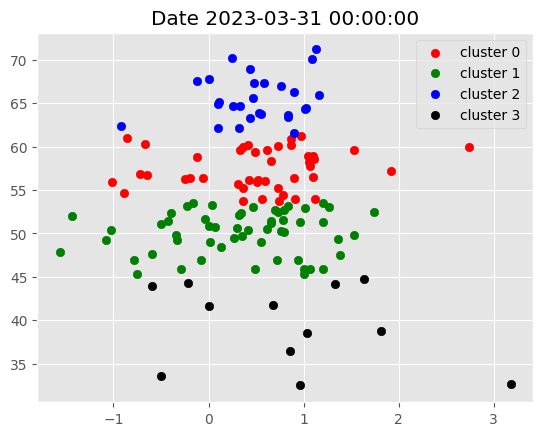

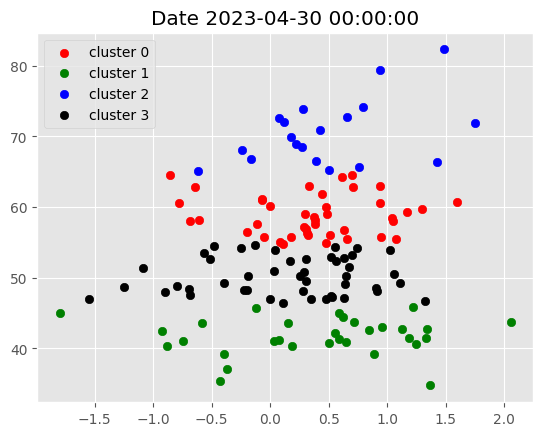

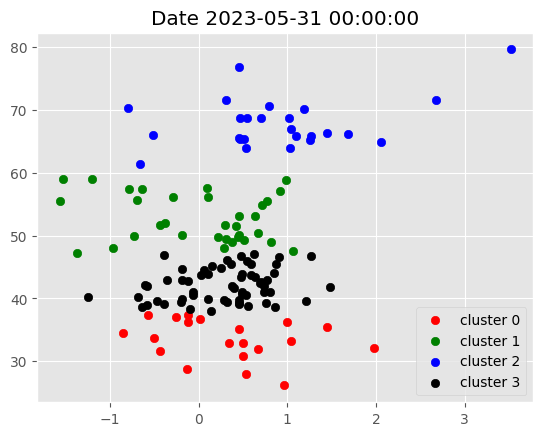

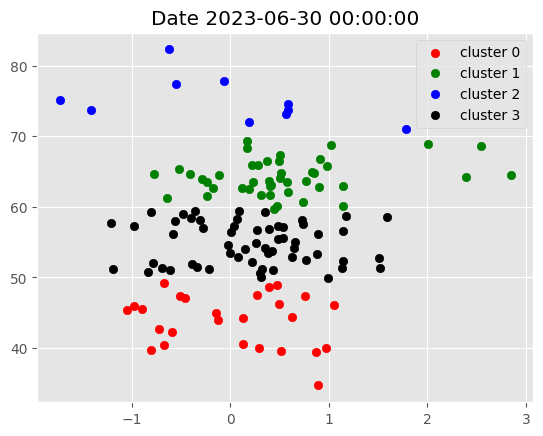

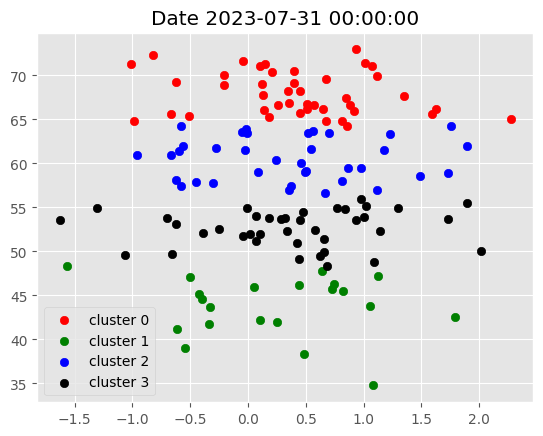

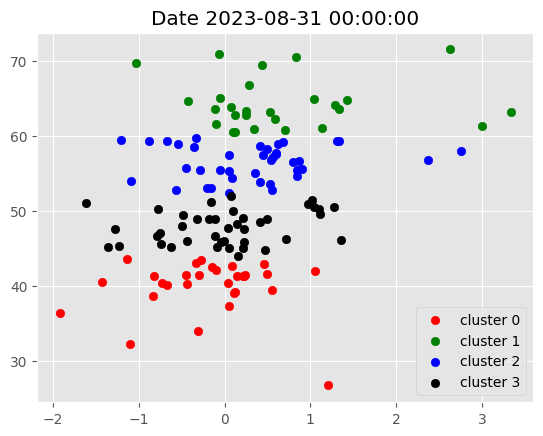

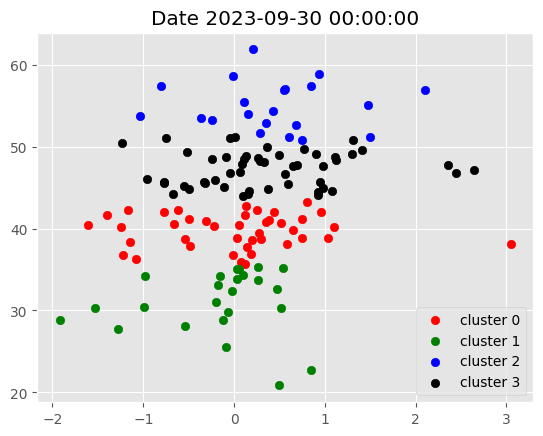

In [ ]:
plt.style.use('ggplot')

for i in data.index.get_level_values('date').unique().tolist():

    g = data.xs(i, level=0)

    plt.title(f'Date {i}')

    plot_clusters(g)

In [ ]:
target_rsi_values = [30, 45, 55, 70]

initial_centroids = np.zeros((len(target_rsi_values), 18))

initial_centroids[:, 6] = target_rsi_values

initial_centroids

array([[ 0.,  0.,  0.,  0.,  0.,  0., 30.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., 45.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., 55.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., 70.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.]])

In [ ]:
filtered_df = data[data['cluster']==3].copy()

filtered_df = filtered_df.reset_index(level=1)

filtered_df.index = filtered_df.index+pd.DateOffset(1)

filtered_df = filtered_df.reset_index().set_index(['date', 'ticker'])

dates = filtered_df.index.get_level_values('date').unique().tolist()

fixed_dates = {}

for d in dates:

    fixed_dates[d.strftime('%Y-%m-%d')] = filtered_df.xs(d, level=0).index.tolist()

fixed_dates

{'2016-11-01': ['AAL',
  'AIG',
  'AXP',
  'BA',
  'BAC',
  'CVX',
  'DAL',
  'DE',
  'EXPE',
  'FCX',
  'FDX',
  'GS',
  'JPM',
  'LMT',
  'MA',
  'MDLZ',
  'MET',
  'MO',
  'MS',
  'MSFT',
  'NEE',
  'NFLX',
  'NXPI',
  'PARA',
  'QCOM',
  'UAL',
  'USB',
  'VLO',
  'WDC'],
 '2016-12-01': ['AMAT',
  'AXP',
  'BA',
  'BRK-B',
  'CAT',
  'CMCSA',
  'COF',
  'COP',
  'CVX',
  'DD',
  'DG',
  'DIS',
  'DLTR',
  'ELV',
  'EOG',
  'FCX',
  'GM',
  'HAL',
  'IBM',
  'LMT',
  'LUV',
  'LVS',
  'MCD',
  'MPC',
  'MRO',
  'MU',
  'PARA',
  'RTX',
  'SBUX',
  'SLB',
  'TGT',
  'TJX',
  'TXN',
  'UNP',
  'UPS',
  'WDC',
  'WFC',
  'WYNN'],
 '2017-01-01': ['AXP',
  'BA',
  'BAC',
  'BRK-B',
  'C',
  'CHTR',
  'COST',
  'CVX',
  'DD',
  'DE',
  'DIS',
  'GE',
  'GS',
  'HAL',
  'IBM',
  'JPM',
  'LUV',
  'MCD',
  'MMM',
  'MO',
  'MPC',
  'MS',
  'MU',
  'PARA',
  'SCHW',
  'T',
  'TSLA',
  'UAL',
  'UNH',
  'USB',
  'VLO',
  'VZ',
  'WDC',
  'WFC',
  'XOM'],
 '2017-02-01': ['AMAT',
  'AMGN',
  'A

In [ ]:
pip install PyPortfolioOpt

In [ ]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

def optimize_weights(prices, lower_bound=0):

    returns = expected_returns.mean_historical_return(prices=prices,
                                                      frequency=252)

    cov = risk_models.sample_cov(prices=prices,
                                 frequency=252)

    ef = EfficientFrontier(expected_returns=returns,
                           cov_matrix=cov,
                           weight_bounds=(lower_bound, .1),
                           solver='SCS')

    weights = ef.max_sharpe()

    return ef.clean_weights()

In [ ]:
stocks = data.index.get_level_values('ticker').unique().tolist()

new_df = yf.download(tickers=stocks,
                     start=data.index.get_level_values('date').unique()[0]-pd.DateOffset(months=12),
                     end=data.index.get_level_values('date').unique()[-1])

new_df

[*********************100%%**********************]  163 of 163 completed


Price       Adj Close                                                 \
Ticker            AAL        AAPL        ABBV        ABT         ACN   
Date                                                                   
2015-11-02  44.313278   27.358980   43.625759  38.523956   93.561623   
2015-11-03  44.437515   27.672804   42.971848  38.591785   93.309471   
2015-11-04  43.606110   27.544111   43.914848  38.311958   92.622543   
2015-11-05  43.577438   27.417145   43.205872  38.311958   92.248657   
2015-11-06  43.328968   27.448887   44.142002  38.693565   92.170395   
...               ...         ...         ...        ...         ...   
2023-09-25  12.910000  175.183563  148.897141  95.484749  311.950897   
2023-09-26  12.700000  171.084549  148.184692  94.269997  305.672333   
2023-09-27  12.610000  169.562317  147.433685  93.584259  309.382416   
2023-09-28  12.920000  169.821014  146.586426  96.121506  295.988770   
2023-09-29  12.810000  170.338364  143.515091  94.877373  302.227997   

Price                                                                  ...  \
Ticker            ADBE         ADP        ADSK        AIG        AMAT  ...   
Date                                                                   ...   
2015-11-02   89.910004   71.992973   56.889999  51.010502   15.164550  ...   
2015-11-03   90.360001   71.777809   57.930000  48.785694   15.263313  ...   
2015-11-04   91.010002   71.968147   57.830002  48.657658   15.146598  ...   
2015-11-05   90.550003   71.984695   63.490002  49.617996   15.092723  ...   
2015-11-06   90.690002   72.522629   63.880001  49.561974   15.308203  ...   
...                ...         ...         ...        ...         ...  ...   
2023-09-25  511.600006  235.844086  205.669998  61.170818  135.818924  ...   
2023-09-26  506.299988  233.112457  201.660004  60.314251  133.323090  ...   
2023-09-27  502.600006  238.408691  202.279999  60.068111  134.297562  ...   
2023-09-28  504.670013  239.076843  207.889999  60.333942  137.439728  ...   
2023-09-29  509.899994  236.394333  206.910004  59.664440  137.668442  ...   

Price        Volume                                                   \
Ticker         VRTX      VTRS        VZ       WBA      WDC       WFC   
Date                                                                   
2015-11-02  1854700   9013000  11689100   6950300  3486000  10992300   
2015-11-03  1811900  11600100  11900900   7044100  4750500  10709100   
2015-11-04  1614400  10610000   9702000   5484800  4621800  12823600   
2015-11-05  1485300   7093800  11646900   3550400  3843300  12263900   
2015-11-06  2526400   6387800  14144400   6129100  2850600  22376800   
...             ...       ...       ...       ...      ...       ...   
2023-09-25   698100   5595100  17616900   6891000  2685900  10624000   
2023-09-26   633600   5884000  18841600   7570500  3571100  15219400   
2023-09-27   860600   8614500  22083500  10182900  2547800  11815500   
2023-09-28   578900   8042500  18772100   7291500  3282000  12454600   
2023-09-29   896800   6365500  19759400  25659100  2512000  13119100   

Price                                             
Ticker           WMT     WYNN       XOM      YUM  
Date                                              
2015-11-02  32157600  4274200  21266500  4055878  
2015-11-03  30761700  4616600  20115900  3707015  
2015-11-04  30169500  4286300  14245400  3273579  
2015-11-05  26581500  2261500  12291100  3596987  
2015-11-06  29931900  2123700  12491700  3502538  
...              ...      ...       ...      ...  
2023-09-25  10459500  1387800  11316000  1048500  
2023-09-26  14435700  1454000  11805400  1500600  
2023-09-27  15711000  2050000  23976200  1922300  
2023-09-28  11617200  1290400  16808100  1722700  
2023-09-29  18842400  1326800  18810700  2610000  

[1991 rows x 978 columns]

In [ ]:
returns_dataframe = np.log(new_df['Adj Close']).diff()

portfolio_df = pd.DataFrame()

for start_date in fixed_dates.keys():

    try:

        end_date = (pd.to_datetime(start_date)+pd.offsets.MonthEnd(0)).strftime('%Y-%m-%d')

        cols = fixed_dates[start_date]

        optimization_start_date = (pd.to_datetime(start_date)-pd.DateOffset(months=12)).strftime('%Y-%m-%d')

        optimization_end_date = (pd.to_datetime(start_date)-pd.DateOffset(days=1)).strftime('%Y-%m-%d')

        optimization_df = new_df[optimization_start_date:optimization_end_date]['Adj Close'][cols]

        success = False
        try:
            weights = optimize_weights(prices=optimization_df,
                                   lower_bound=round(1/(len(optimization_df.columns)*2),3))

            weights = pd.DataFrame(weights, index=pd.Series(0))

            success = True
        except:
            print(f'Max Sharpe Optimization failed for {start_date}, Continuing with Equal-Weights')

        if success==False:
            weights = pd.DataFrame([1/len(optimization_df.columns) for i in range(len(optimization_df.columns))],
                                     index=optimization_df.columns.tolist(),
                                     columns=pd.Series(0)).T

        temp_df = returns_dataframe[start_date:end_date]

        temp_df = temp_df.stack().to_frame('return').reset_index(level=0)\
                   .merge(weights.stack().to_frame('weight').reset_index(level=0, drop=True),
                          left_index=True,
                          right_index=True)\
                   .reset_index().set_index(['Date', 'index']).unstack().stack()

        temp_df.index.names = ['date', 'ticker']

        temp_df['weighted_return'] = temp_df['return']*temp_df['weight']

        temp_df = temp_df.groupby(level=0)['weighted_return'].sum().to_frame('Strategy Return')

        portfolio_df = pd.concat([portfolio_df, temp_df], axis=0)

    except Exception as e:
        print(e)

portfolio_df = portfolio_df.drop_duplicates()

portfolio_df

"None of ['index'] are in the columns"
"None of ['index'] are in the columns"
"None of ['index'] are in the columns"
"None of ['index'] are in the columns"
"None of ['index'] are in the columns"
"None of ['index'] are in the columns"
"None of ['index'] are in the columns"
"None of ['index'] are in the columns"
"None of ['index'] are in the columns"
"None of ['index'] are in the columns"
"None of ['index'] are in the columns"
"None of ['index'] are in the columns"
"None of ['index'] are in the columns"
"None of ['index'] are in the columns"
"None of ['index'] are in the columns"
"None of ['index'] are in the columns"
"None of ['index'] are in the columns"
"None of ['index'] are in the columns"
"None of ['index'] are in the columns"
"None of ['index'] are in the columns"
"None of ['index'] are in the columns"
"None of ['index'] are in the columns"
"None of ['index'] are in the columns"
"None of ['index'] are in the columns"
"None of ['index'] are in the columns"
"None of ['index'] are in

""


from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['index']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'index'}, axis=1)
              .sort_values('index', ascending=True))
  xs = counted['index']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_0.sort_values('index', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('count()')